In [1]:
import os
import copy
import random

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

In [3]:
# Функции для нарезки и подготовки
############################################


def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


def train_test_split(data, N_parts, num_of_part):
    N_samples = len(data)
    l_idx = int((N_samples * num_of_part) / N_parts)
    return data[:l_idx], data[l_idx:]


def slicer(data, label, fs, windowlen=500, timestep=100):
    data_len = len(data)
    ts_samp = int((timestep * fs) / 1000)
    wl_samp = int((windowlen * fs) / 1000)
    start = np.arange(0, data_len - wl_samp, ts_samp)[:, None]
    idxs = start + np.arange(0, wl_samp)[None, :]
    X = data[idxs].transpose(0, 2, 1)
    y = label[start[:, 0] + wl_samp]
    return X, y


def prepare_sequences(X: np.ndarray, y: np.ndarray, seq_len: int):
    # X: (T, feat_dim), y: (T, out_dim)
    T, feat = X.shape
    _, out = y.shape
    n_seq = T - seq_len + 1
    Xs = np.zeros((n_seq, seq_len, feat), dtype=X.dtype)
    Ys = np.zeros((n_seq, seq_len, out), dtype=y.dtype)
    for i in range(n_seq):
        Xs[i] = X[i : i + seq_len]
        Ys[i] = y[i : i + seq_len]
    return Xs, Ys


def prepare_single_sequence(X: np.ndarray, seq_len: int):
    T, feat = X.shape
    if T < seq_len:
        pad = np.zeros((seq_len - T, feat), dtype=X.dtype)
        X = np.vstack([pad, X])
    return X[None, -seq_len:, :]


def contains_any_substring(s, substrings):
    return any(sub in s for sub in substrings)


class DTWScore(BaseEstimator):
    """
    Кастомная метрика DTW в стиле sklearn.
    Использует fastdtw для эффективного вычисления расстояния.
    Поддерживает одномерные и многомерные последовательности.
    """

    def __init__(self, normalize=True):
        self.normalize = normalize  # делить на длину или нет

    def score(self, y_true, y_pred):
        """
        y_true, y_pred: массивы формы (T, D) или (T,) — временные последовательности
        """
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)

        distance, _ = fastdtw(y_true, y_pred, dist=euclidean)

        if self.normalize:
            return -distance / len(y_true)  # чем ближе к 0, тем лучше
        else:
            return -distance

    def __call__(self, y_true, y_pred):
        return self.score(y_true, y_pred)

#### Fedor

In [ ]:
# subj_path = "..\\data\\Fedor\\Preprocessed\\1\\"
# n_files = 4
# n_parts = 10
# train_num_of_part = 8
# fs = 250

# data_list_train = list()
# data_list_test = list()
# label_list_train = list()
# label_list_test = list()

# for i in range(n_files):

#     arr = np.load(subj_path + "000" + str(i) + ".npz")

#     data = arr["data_myo"]
#     label = arr["data_angles"]

#     data_train, data_test = train_test_split(data, n_parts, train_num_of_part)
#     label_train, label_test = train_test_split(label, n_parts, train_num_of_part)

#     data_list_train.append(data_train)
#     data_list_test.append(data_test)

#     label_list_train.append(label_train)
#     label_list_test.append(label_test)

# data_train = np.concatenate(data_list_train, axis=0)
# data_test = np.concatenate(data_list_test, axis=0)

# label_train = np.concatenate(label_list_train, axis=0)
# label_test = np.concatenate(label_list_test, axis=0)

# X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
# X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [52]:
# Training Selection | Validation V2

root_dir = r"D:\study\myo\emg-virtual\data\Fedor_Jan\Preprocessed"
files = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith(".npz"):
            full_path = os.path.join(dirpath, filename)
            files.append(full_path)


n_parts = 10
train_num_of_part = 8
fs = 250

data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

for fname in files:

    if not "Simple2_5" in fname:
        continue

    arr = np.load(fname)

    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, n_parts, train_num_of_part)
    label_train, label_test = train_test_split(label, n_parts, train_num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)

label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2132, 8, 128), (532, 8, 128), (2132, 20), (532, 20))

In [ ]:
# All data | Validation V2
# Mean correlation: 0.912 ± 0.063
# Individual correlations: ['0.940', '0.802', '0.953', '0.958', '0.951', '0.777', '0.949', '0.954', '0.957', '0.795', '0.948', '0.954', '0.955', '0.792', '0.938', '0.949', '0.935', '0.884', '0.914', '0.935']

# Mean R2: 0.833 ± 0.109
# Individual R2: ['0.880', '0.639', '0.907', '0.917', '0.902', '0.602', '0.899', '0.906', '0.913', '0.625', '0.896', '0.908', '0.908', '0.628', '0.876', '0.897', '0.873', '0.781', '0.834', '0.872']

root_dir = r"D:\study\myo\emg-virtual\data\Fedor_Jan\Preprocessed"
files = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith(".npz"):
            full_path = os.path.join(dirpath, filename)
            files.append(full_path)


n_parts = 10
train_num_of_part = 8
fs = 250

data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

for fname in files:

    # if not "Simple1" in fname:
    #     continue

    arr = np.load(fname)

    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, n_parts, train_num_of_part)
    label_train, label_test = train_test_split(label, n_parts, train_num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)

label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27743, 8, 128), (6935, 8, 128), (27743, 20), (6935, 20))

In [4]:
# All data | Validation V1

subj_path = "../data/Fedor_Jan/Preprocessed/"
files = sorted(os.listdir(subj_path))

fs = 250
# Списки
data_list_train, data_list_test = [], []
label_list_train, label_list_test = [], []

train_files_subnames = [
    "Simple2_1",
    "Simple2_2",
    "Simple2_3",
    "Simple2_4",
    "Simple2_5",
]
test_files_subnames = [
    # "Simple1_1",
    "Simple1_2",
    "Simple1_3",
    "Simple1_4",
    "Simple1_5",
]


for fname in files:
    arr = np.load(os.path.join(subj_path, fname))
    data, label = arr["data_myo"], arr["data_angles"]

    if contains_any_substring(fname, test_files_subnames):
        data_list_test.append(data)
        label_list_test.append(label)
        continue

    if contains_any_substring(fname, train_files_subnames):
        data_list_train.append(data)
        label_list_train.append(label)
        continue

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)
label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

print("Train windows:", X_train.shape, "→", y_train.shape)
print("Test  windows:", X_test.shape, "→", y_test.shape)

Train windows: (16895, 8, 128) → (16895, 20)
Test  windows: (14227, 8, 128) → (14227, 20)


#### Oleg

In [27]:
# Training Selection | Validation V2

root_dir = r"D:\study\myo\emg-virtual\data\Oleg\Preprocessed\Simple1"
files = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith(".npz"):
            full_path = os.path.join(dirpath, filename)
            files.append(full_path)


n_parts = 10
train_num_of_part = 8
fs = 250

data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

for fname in files:

    arr = np.load(fname)

    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, n_parts, train_num_of_part)
    label_train, label_test = train_test_split(label, n_parts, train_num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)

label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12805, 8, 128), (3200, 8, 128), (12805, 20), (3200, 20))

In [34]:
root_dir = r"D:\study\myo\emg-virtual\data\Oleg\Preprocessed\Simple1"
files = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith(".npz"):
            full_path = os.path.join(dirpath, filename)
            files.append(full_path)

files[-10:]

['D:\\study\\myo\\emg-virtual\\data\\Oleg\\Preprocessed\\Simple1\\4\\0002.npz',
 'D:\\study\\myo\\emg-virtual\\data\\Oleg\\Preprocessed\\Simple1\\4\\0003.npz',
 'D:\\study\\myo\\emg-virtual\\data\\Oleg\\Preprocessed\\Simple1\\5\\0000.npz',
 'D:\\study\\myo\\emg-virtual\\data\\Oleg\\Preprocessed\\Simple1\\5\\0001.npz',
 'D:\\study\\myo\\emg-virtual\\data\\Oleg\\Preprocessed\\Simple1\\5\\0002.npz',
 'D:\\study\\myo\\emg-virtual\\data\\Oleg\\Preprocessed\\Simple1\\5\\0003.npz',
 'D:\\study\\myo\\emg-virtual\\data\\Oleg\\Preprocessed\\Simple1\\5\\0004.npz',
 'D:\\study\\myo\\emg-virtual\\data\\Oleg\\Preprocessed\\Simple1\\5\\0005.npz',
 'D:\\study\\myo\\emg-virtual\\data\\Oleg\\Preprocessed\\Simple1\\5\\0006.npz',
 'D:\\study\\myo\\emg-virtual\\data\\Oleg\\Preprocessed\\Simple1\\5\\0007.npz']

In [61]:
# All data | Validation V1

root_dir = r"D:\study\myo\emg-virtual\data\Oleg\Preprocessed\Simple1"
files = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith(".npz"):
            full_path = os.path.join(dirpath, filename)
            files.append(full_path)

fs = 250
# Списки
data_list_train, data_list_test = [], []
label_list_train, label_list_test = [], []

train_files_subnames = ["Simple1\\1", "Simple1\\2", "Simple1\\4", "Simple1\\5"]
test_files_subnames = ["Simple1\\3"]


for fname in files:
    arr = np.load(os.path.join(subj_path, fname))
    data, label = arr["data_myo"], arr["data_angles"]

    if contains_any_substring(fname, test_files_subnames):
        data_list_test.append(data)
        label_list_test.append(label)
        continue

    if contains_any_substring(fname, train_files_subnames):
        data_list_train.append(data)
        label_list_train.append(label)
        continue

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)
label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

print("Train windows:", X_train.shape, "→", y_train.shape)
print("Test  windows:", X_test.shape, "→", y_test.shape)

Train windows: (12449, 8, 128) → (12449, 20)
Test  windows: (3556, 8, 128) → (3556, 20)


#### Alexander Chevcov

In [118]:
subj_path = "..\\data\\Alexander Chevcov\\Preprocessed_Separate_Days\\Simple2\\"
fs = 250
n_channels = 6


N_files = 8
data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

N_parts = 10
num_of_part = 8

for i in range(N_files):

    arr = np.load(subj_path + "Raw_Simple2_000" + str(i) + ".npz")

    data = arr["data_myo"]
    label = arr["data_angles"]

    data = data[:, :n_channels]

    data_train, data_test = train_test_split(data, N_parts, num_of_part)
    label_train, label_test = train_test_split(label, N_parts, num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)


data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)


label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2842, 6, 128), (709, 6, 128), (2842, 20), (709, 20))

In [54]:
############################################
# 2) Пример запуска — выбор данных на
# обучение и валидацию вручную
############################################

# Параметры
subj_path = "../data/Alexander Chevcov/Old_Preprocessed/Preprocessed/"
files = sorted(os.listdir(subj_path))
n_parts = 10
train_num_of_part = 8
fs = 500
n_channels = 6

# Списки
data_list_train, data_list_test = [], []
label_list_train, label_list_test = [], []

test_files_subnames = ["Simple_3_"]
train_files_subnames = ["Simple_1_", "Simple_2_"]

for fname in files:
    arr = np.load(os.path.join(subj_path, fname))
    data, label = arr["data_myo"], arr["data_angles"]
    data = data[:, :n_channels]

    if contains_any_substring(fname, test_files_subnames):
        data_list_test.append(data)
        label_list_test.append(label)
        continue

    if contains_any_substring(fname, train_files_subnames):
        data_list_train.append(data)
        label_list_train.append(label)
        continue

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)
label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=256, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=256, timestep=200)

print("Train windows:", X_train.shape, "→", y_train.shape)
print("Test  windows:", X_test.shape, "→", y_test.shape)

Train windows: (7111, 6, 128) → (7111, 20)
Test  windows: (3547, 6, 128) → (3547, 20)


In [23]:
subj_path = "..\\data\\Alexander Chevcov\\Old_Preprocessed\\Simple1\\"
fs = 500
n_channels = 6


def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


def train_test_split(data, N_parts, num_of_part):
    N_samples = len(data)

    l_idx = int((N_samples * num_of_part) / N_parts)
    data_train = data[:l_idx, :]
    data_test = data[l_idx:, :]

    return data_train, data_test


N_files = 8
data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

N_parts = 10
num_of_part = 8

for i in range(N_files):

    arr = np.load(subj_path + "000" + str(i) + ".npz")

    std_coef = arr["std_coef"]
    data = arr["data_myo"]
    label = arr["data_angles"]

    data = data[:, :n_channels]

    data_train, data_test = train_test_split(data, N_parts, num_of_part)
    label_train, label_test = train_test_split(label, N_parts, num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)


data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)


label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)


def slicer(data, label, fs, windowlen=500, timestep=100):
    data_len = len(data)
    timestep_samples = int((timestep * fs) / 1000)
    windowlen_samples = int((windowlen * fs) / 1000)
    start_idc = np.arange(0, data_len - windowlen_samples, timestep_samples)[:, None]
    window_idc = np.arange(0, windowlen_samples)[None, :]
    slice_idc = start_idc + window_idc
    slice_data = data[slice_idc].transpose(0, 2, 1)
    slice_label = label[start_idc[:, 0] + windowlen_samples]
    return slice_data, slice_label


X_train, y_train = slicer(data_train, label_train, fs, windowlen=256, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=256, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2844, 6, 128), (710, 6, 128), (2844, 20), (710, 20))

In [14]:
############################################
# 2) Пример запуска — выбор данных на
# обучение и валидацию вручную
############################################

# Параметры
subj_path = "../data/Alexander Chevcov/Preprocessed/"
files = sorted(os.listdir(subj_path))
n_parts = 10
train_num_of_part = 8
fs = 250
n_channels = 6

# Списки
data_list_train, data_list_test = [], []
label_list_train, label_list_test = [], []

test_files_subnames = ["Simple2_"]
train_files_subnames = ["Simple1_", "Simple3_"]

for fname in files:
    arr = np.load(os.path.join(subj_path, fname))
    data, label = arr["data_myo"], arr["data_angles"]
    data = data[:, :n_channels]

    if contains_any_substring(fname, test_files_subnames):
        data_list_test.append(data)
        label_list_test.append(label)
        continue

    if contains_any_substring(fname, train_files_subnames):
        data_list_train.append(data)
        label_list_train.append(label)
        continue

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)
label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

print("Train windows:", X_train.shape, "→", y_train.shape)
print("Test  windows:", X_test.shape, "→", y_test.shape)

Train windows: (7102, 6, 128) → (7102, 20)
Test  windows: (3554, 6, 128) → (3554, 20)


In [56]:
# All data | Validation V2

root_dir = r"D:\study\myo\emg-virtual\data\Alexander Chevcov\Preprocessed"
files = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith(".npz"):
            full_path = os.path.join(dirpath, filename)
            files.append(full_path)


n_parts = 10
train_num_of_part = 8
fs = 250

data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

for fname in files:

    if "Simple2" in fname:
        continue

    arr = np.load(fname)

    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, n_parts, train_num_of_part)
    label_train, label_test = train_test_split(label, n_parts, train_num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)

label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5681, 6, 128), (1419, 6, 128), (5681, 20), (1419, 20))

#### Peter

In [74]:
subj_path = "..\\data\\Peter\\Preprocessed\\Simple1\\"
fs = 250
n_channels = 6


N_files = 8
data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

N_parts = 10
num_of_part = 8

for i in range(N_files):

    arr = np.load(subj_path + "Raw_Simple1_000" + str(i) + ".npz")

    data = arr["data_myo"]
    label = arr["data_angles"]

    data = data[:, :n_channels]

    data_train, data_test = train_test_split(data, N_parts, num_of_part)
    label_train, label_test = train_test_split(label, N_parts, num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)


data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)


label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2835, 6, 128), (707, 6, 128), (2835, 20), (707, 20))

In [15]:
subj_path = "..\\data\\Peter\\Old_Preprocessed\\"
fs = 500
n_channels = 6


N_files = 8
data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

N_parts = 10
num_of_part = 9

for i in range(N_files):

    arr = np.load(subj_path + "000" + str(i) + ".npz")

    data = arr["data_myo"]
    label = arr["data_angles"]

    data = data[:, :n_channels]

    data_train, data_test = train_test_split(data, N_parts, num_of_part)
    label_train, label_test = train_test_split(label, N_parts, num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)


data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)


label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=256, timestep=100)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=256, timestep=100)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6381, 6, 128), (707, 6, 128), (6381, 20), (707, 20))

#### Alexander K

In [85]:
subj_path = "..\\data\\Alexander K\\Preprocessed\\Simple1\\"
fs = 250
n_channels = 6


N_files = 8
data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

N_parts = 10
num_of_part = 8

for i in range(N_files):

    arr = np.load(subj_path + "Raw_Simple1_000" + str(i) + ".npz")

    data = arr["data_myo"]
    label = arr["data_angles"]

    data = data[:, :n_channels]

    data_train, data_test = train_test_split(data, N_parts, num_of_part)
    label_train, label_test = train_test_split(label, N_parts, num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)


data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)


label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2844, 6, 128), (709, 6, 128), (2844, 20), (709, 20))

#### Nastya

In [3]:
# Validation V2

root_dir = r"D:\study\myo\emg-virtual\data\Nastya\Simple\Preprocessed"
files = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith(".npz"):
            full_path = os.path.join(dirpath, filename)
            files.append(full_path)

fs = 250
n_channels = 8
n_parts = 10
train_num_of_part = 8

data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

for fname in files:

    # if not "Simple1" in fname:
    #     continue

    arr = np.load(fname)

    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, n_parts, train_num_of_part)
    label_train, label_test = train_test_split(label, n_parts, train_num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)

label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((54082, 8, 128), (13521, 8, 128), (54082, 20), (13521, 20))

In [17]:
root_dir = r"D:\study\myo\emg-virtual\data\Nastya\Simple\Preprocessed"
files = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith(".npz"):
            full_path = os.path.join(dirpath, filename)
            files.append(full_path)

fs = 250
n_channels = 8

data_list_train, data_list_test = [], []
label_list_train, label_list_test = [], []

test_files_subnames = [
    "Simple3\\1",
    "Simple3\\2",
    "Simple3\\3",
    "Simple3\\4",
    "Simple3\\5",
]

train_files_subnames = [
    "Simple1\\1",
    "Simple1\\3",
    "Simple1\\4",
    "Simple1\\5",
    "Simple2\\1",
    "Simple2\\2",
    "Simple2\\3",
    # "Simple3\\1",
    # "Simple3\\2",
    # "Simple3\\4",
    # "Simple3\\5",
    # "Simple4\\1",
    # "Simple4\\2",
    # "Simple4\\4",
    # "Simple4\\5",
]

for fname in files:
    arr = np.load(fname)
    data, label = arr["data_myo"], arr["data_angles"]
    data = data[:, :n_channels]

    if contains_any_substring(fname, test_files_subnames):
        data_list_test.append(data)
        label_list_test.append(label)
        continue

    if contains_any_substring(fname, train_files_subnames):
        data_list_train.append(data)
        label_list_train.append(label)
        continue

data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)
label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

X_train, y_train = slicer(data_train, label_train, fs, windowlen=512, timestep=200)
X_test, y_test = slicer(data_test, label_test, fs, windowlen=512, timestep=200)

print("Train windows:", X_train.shape, "→", y_train.shape)
print("Test  windows:", X_test.shape, "→", y_test.shape)

Train windows: (24907, 8, 128) → (24907, 20)
Test  windows: (17792, 8, 128) → (17792, 20)


#### Mary

#### Model

In [91]:
# class EMGDecoderLSTM(nn.Module):
#     def __init__(self, feat_dim: int, hidden_dim: int, output_dim: int):
#         super().__init__()
#         # LSTMCell — шаг авторегрессии
#         self.linear = nn.Linear(feat_dim + output_dim, hidden_dim)
#         self.lstm_cell = nn.LSTMCell(hidden_dim, hidden_dim)
#         self.mlp = nn.Sequential(
#             # nn.Linear(hidden_dim, hidden_dim),
#             # nn.GELU(),
#             nn.Linear(hidden_dim, output_dim),
#         )
#         self.hidden_dim = hidden_dim
#         self.output_dim = output_dim

#     def forward_step(
#         self,
#         features: torch.Tensor,
#         prev_output: torch.Tensor,
#         hidden: torch.Tensor = None,
#         cell: torch.Tensor = None,
#     ):
#         batch_size = features.size(0)
#         device = features.device

#         if hidden is None:
#             hidden = torch.zeros(batch_size, self.hidden_dim, device=device)

#         if cell is None:
#             cell = torch.zeros(batch_size, self.hidden_dim, device=device)

#         inp = torch.cat([features, prev_output], dim=1)  # (batch, feat+out)
#         inp = self.linear(inp)
#         new_hidden, new_cell = self.lstm_cell(
#             inp, (hidden, cell)
#         )  # (batch, hidden_dim)
#         pred = self.mlp(new_hidden)  # (batch, output_dim)
#         return pred, new_hidden, new_cell


# class EMGDecoderLSTM(nn.Module):
#     def __init__(
#         self, feat_dim: int, hidden_dim: int, output_dim: int, dropout: float = 0.2
#     ):
#         super().__init__()
#         self.linear = nn.Linear(feat_dim + output_dim, hidden_dim)
#         self.inp_norm = nn.LayerNorm(hidden_dim)
#         self.inp_dropout = nn.Dropout(dropout)

#         self.lstm_cell = nn.LSTMCell(hidden_dim, hidden_dim)
#         self.hidden_norm = nn.LayerNorm(hidden_dim)
#         self.hidden_dropout = nn.Dropout(dropout)

#         self.mlp = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.GELU(),
#             nn.LayerNorm(hidden_dim),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dim, output_dim),
#         )
#         self.hidden_dim = hidden_dim
#         self.output_dim = output_dim

#     def forward_step(
#         self,
#         features: torch.Tensor,
#         prev_output: torch.Tensor,
#         hidden: torch.Tensor = None,
#         cell: torch.Tensor = None,
#     ):
#         batch_size, device = features.size(0), features.device

#         if hidden is None or cell is None:
#             hidden = torch.zeros(batch_size, self.hidden_dim, device=device)
#             cell = torch.zeros(batch_size, self.hidden_dim, device=device)

#         # 1) входной линейный слой + norm + dropout
#         inp = torch.cat([features, prev_output], dim=1)
#         inp = self.linear(inp)
#         # inp = self.inp_norm(inp)
#         inp = self.inp_dropout(inp)

#         # 2) LSTMCell
#         new_hidden, new_cell = self.lstm_cell(inp, (hidden, cell))

#         # 3) norm + dropout на скрытом состоянии
#         h = self.hidden_norm(new_hidden)
#         h = self.hidden_dropout(h)

#         # 4) выводной MLP
#         pred = self.mlp(h)
#         return pred, new_hidden, new_cell


class EMGDecoderLSTM(nn.Module):
    def __init__(
        self, feat_dim: int, hidden_dim: int, output_dim: int, dropout: float = 0.2
    ):
        super().__init__()
        self.linear = nn.Linear(feat_dim + output_dim, hidden_dim)
        self.inp_dropout = nn.Dropout(dropout)

        self.lstm_cell = nn.LSTMCell(hidden_dim, hidden_dim)
        self.hidden_dropout = nn.Dropout(dropout)

        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
        )
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

    def forward_step(
        self,
        features: torch.Tensor,
        prev_output: torch.Tensor,
        hidden: torch.Tensor = None,
        cell: torch.Tensor = None,
    ):
        batch_size, device = features.size(0), features.device

        if hidden is None:
            hidden = torch.zeros(batch_size, self.hidden_dim, device=device)
        if cell is None:
            cell = torch.zeros(batch_size, self.hidden_dim, device=device)

        # 1) входной линейный слой + dropout
        inp = torch.cat([features, prev_output], dim=1)
        inp = self.linear(inp)
        inp = self.inp_dropout(inp)

        # 2) LSTMCell
        new_hidden, new_cell = self.lstm_cell(inp, (hidden, cell))

        # 3) dropout на скрытом состоянии
        h = self.hidden_dropout(new_hidden)

        # 4) выводной MLP
        pred = self.mlp(h)
        return pred, new_hidden, new_cell


class RiemannLSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator: str = "oas",
        metric: str = "riemann",
        hidden_dim: int = 64,
        seq_len: int = 20,
        lr: float = 1e-3,
        alpha: float = 1e-5,
        max_iter: int = 50,
        batch_size: int = 32,
        device: str = "cpu",
        verbose: bool = False,
        save_best: bool = True,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.lr = lr
        self.alpha = alpha
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.device = device
        self.verbose = verbose
        self.save_best = save_best

        # будут инициализированы в fit
        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    def fit(
        self, X: np.ndarray, y: np.ndarray, X_val=None, y_val=None, load_checkpoint=None
    ):
        # X: (n_windows, n_ch, n_time), y: (n_windows, 20)
        # 1) Riemann-признаки
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)  # (T, feat_dim)

        # 2) Переход к numpy, чтобы сформировать sequences
        X_seq, y_seq = prepare_sequences(X_ts, y, self.seq_len)
        # X_seq: (n_seq, seq_len, feat); y_seq: (n_seq, seq_len, 20)

        # 3) В даталоадер подаём X_seq и y_seq
        # Сшиваем по последнему измерению: для каждой позиции t обучаем модель последовательно
        # но DataLoader вернёт полный seq.
        dataset = TensorDataset(
            torch.tensor(X_seq, dtype=torch.float32),
            torch.tensor(y_seq, dtype=torch.float32),
        )
        loader = DataLoader(
            dataset, batch_size=self.batch_size, shuffle=True, drop_last=True
        )

        # 4) Создаём модель
        feat_dim = X_ts.shape[1]
        output_dim = y.shape[1]
        self.model_ = EMGDecoderLSTM(feat_dim, self.hidden_dim, output_dim).to(
            self.device
        )

        if load_checkpoint:
            self.model_.load_state_dict(
                torch.load(load_checkpoint, map_location=self.device)
            )
            print(f"Checkpoint loaded from {load_checkpoint}")

        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            self.model_.parameters(), lr=self.lr, weight_decay=self.alpha
        )
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=self.max_iter // 2, gamma=0.7
        )

        best_val_loss = float("inf")
        best_model_state = None

        # 5) Тренировочный цикл с teacher forcing
        for epoch in range(self.max_iter):
            self.model_.train()
            epoch_loss = 0.0
            for Xb, yb in loader:
                # Xb: (B, seq_len, feat), yb: (B, seq_len, out)
                Xb = Xb.to(self.device)
                yb = yb.to(self.device)
                batch_size = Xb.size(0)

                prev_pred = torch.zeros(batch_size, output_dim, device=self.device)
                hidden = None
                cell = None
                loss_batch = 0.0

                for t in range(self.seq_len):
                    feat_t = Xb[:, t, :]
                    target_t = yb[:, t, :]
                    pred_t, hidden, cell = self.model_.forward_step(
                        feat_t, prev_pred, hidden, cell
                    )
                    loss_batch += criterion(pred_t, target_t)
                    # teacher forcing
                    prev_pred = target_t.detach()

                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
                epoch_loss += loss_batch.item()

            scheduler.step()

            if self.verbose and epoch % 5 == 0:
                # --- Тренировочные метрики ---
                train_preds = self.predict(X)
                mse_train = np.mean((train_preds - y) ** 2)
                corrs = [
                    np.corrcoef(train_preds[:, i], y[:, i])[0, 1]
                    for i in range(y.shape[1])
                ]
                mean_corr = np.nanmean(corrs)
                r2 = r2_score(y, train_preds)

                msg = (
                    f"Epoch {epoch}/{self.max_iter} | "
                    f"AvgBatchLoss: {epoch_loss/len(loader):.4f} | "
                    f"Train MSE: {mse_train:.4f}, Corr: {mean_corr:.3f}, R2: {r2:.3f}"
                )

                # --- Валидационные метрики (если есть) ---
                if X_val is not None and y_val is not None:
                    val_preds = self.predict(X_val)
                    mse_val = np.mean((val_preds - y_val) ** 2)
                    corrs_val = [
                        np.corrcoef(val_preds[:, i], y_val[:, i])[0, 1]
                        for i in range(y_val.shape[1])
                    ]
                    mean_corr_val = np.nanmean(corrs_val)
                    r2_val = r2_score(y_val, val_preds)
                    msg += (
                        f" | Val MSE: {mse_val:.4f}, Corr: {mean_corr_val:.3f}, "
                        f"R2: {r2_val:.3f}"
                    )

                    # --- Сохраняем лучшую модель
                    if mse_val < best_val_loss:
                        best_val_loss = mse_val
                        best_model_state = copy.deepcopy(self.model_.state_dict())

                print(msg)

        if best_model_state is not None and self.save_best:
            self.model_.load_state_dict(best_model_state)

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Блочное предсказание (batch of windows), но без teacher forcing:
        # 1) ковариации → ts
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)  # (T, feat_dim)
        X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)

        self.model_.eval()
        preds = []
        prev_pred = torch.zeros(1, self.model_.output_dim, device=self.device)
        hidden = None
        cell = None

        with torch.no_grad():
            for feat in X_ts:
                feat = feat.unsqueeze(0)  # (1, feat_dim)
                pred_t, hidden, cell = self.model_.forward_step(
                    feat, prev_pred, hidden, cell
                )
                preds.append(pred_t.cpu().numpy().ravel())
                prev_pred = pred_t

        return np.vstack(preds)  # (T, output_dim)

    def save_model(self, path: str) -> None:
        """
        Сохраняет только веса модели в файл.
        """
        torch.save(self.model_.state_dict(), path)

In [5]:
class EMGDecoderLSTM(nn.Module):
    def __init__(
        self, feat_dim: int, hidden_dim: int, output_dim: int, dropout: float = 0.2
    ):
        super().__init__()
        self.linear = nn.Linear(feat_dim + output_dim, hidden_dim)
        self.inp_norm = nn.LayerNorm(hidden_dim)
        self.inp_dropout = nn.Dropout(dropout)

        self.lstm_cell = nn.LSTMCell(hidden_dim, hidden_dim)
        self.hidden_norm = nn.LayerNorm(hidden_dim)
        self.hidden_dropout = nn.Dropout(dropout)

        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
        )
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

    def forward_step(
        self,
        features: torch.Tensor,
        prev_output: torch.Tensor,
        hidden: torch.Tensor = None,
        cell: torch.Tensor = None,
    ):
        batch_size, device = features.size(0), features.device

        if hidden is None or cell is None:
            hidden = torch.zeros(batch_size, self.hidden_dim, device=device)
            cell = torch.zeros(batch_size, self.hidden_dim, device=device)

        # 1) входной линейный слой + norm + dropout
        inp = torch.cat([features, prev_output], dim=1)
        inp = self.linear(inp)
        inp = self.inp_norm(inp)
        inp = self.inp_dropout(inp)

        # 2) LSTMCell
        new_hidden, new_cell = self.lstm_cell(inp, (hidden, cell))

        # 3) norm + dropout на скрытом состоянии
        h = self.hidden_norm(new_hidden)
        h = self.hidden_dropout(h)

        # 4) выводной MLP
        pred = self.mlp(h)
        return pred, new_hidden, new_cell


class RiemannLSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator: str = "oas",
        metric: str = "riemann",
        hidden_dim: int = 64,
        seq_len: int = 20,
        lr: float = 1e-3,
        alpha: float = 1e-5,
        max_iter: int = 50,
        batch_size: int = 32,
        device: str = "cpu",
        verbose: bool = False,
        save_best: bool = True,
        patience: int = 5,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.lr = lr
        self.alpha = alpha
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.device = device
        self.verbose = verbose
        self.save_best = save_best
        self.patience = patience

        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    def fit(
        self, X: np.ndarray, y: np.ndarray, X_val=None, y_val=None, load_checkpoint=None
    ):
        # 1) Сплит по сессиям/сериям до нормализации
        # (предполагаем, что X и X_val уже разделены пользователем)
        # 2) Riemann-признаки только на train
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov_train = self.cov_.fit_transform(X)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts_train = self.ts_.fit_transform(X_cov_train)

        if X_val is not None:
            X_cov_val = self.cov_.transform(X_val)
            X_ts_val = self.ts_.transform(X_cov_val)

        # 3) prepare sequences
        X_seq, y_seq = prepare_sequences(X_ts_train, y, self.seq_len)
        if X_val is not None:
            X_seq_val, y_seq_val = prepare_sequences(X_ts_val, y_val, self.seq_len)

        # 4) dataloaders
        train_ds = TensorDataset(
            torch.tensor(X_seq, dtype=torch.float32),
            torch.tensor(y_seq, dtype=torch.float32),
        )
        train_loader = DataLoader(
            train_ds, batch_size=self.batch_size, shuffle=True, drop_last=True
        )
        if X_val is not None:
            val_ds = TensorDataset(
                torch.tensor(X_seq_val, dtype=torch.float32),
                torch.tensor(y_seq_val, dtype=torch.float32),
            )
            val_loader = DataLoader(
                val_ds, batch_size=self.batch_size, shuffle=False, drop_last=True
            )

        # 5) модель
        feat_dim = X_ts_train.shape[1]
        output_dim = y.shape[1]
        self.model_ = EMGDecoderLSTM(feat_dim, self.hidden_dim, output_dim).to(
            self.device
        )
        if load_checkpoint:
            self.model_.load_state_dict(
                torch.load(load_checkpoint, map_location=self.device)
            )
            print(f"Checkpoint loaded from {load_checkpoint}")

        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            self.model_.parameters(), lr=self.lr, weight_decay=self.alpha
        )
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=3, verbose=self.verbose
        )

        best_val_loss = float("inf")
        epochs_no_improve = 0
        best_state = None

        # 6) тренировочный цикл с scheduled sampling
        for epoch in range(self.max_iter):
            self.model_.train()
            total_loss = 0
            for Xb, yb in train_loader:
                Xb, yb = Xb.to(self.device), yb.to(self.device)
                prev = torch.zeros(Xb.size(0), output_dim, device=self.device)
                hidden, cell = None, None
                loss_batch = 0
                # scheduled sampling ratio
                teach_forcing_ratio = max(0.5 * (1 - epoch / self.max_iter), 0.1)

                for t in range(self.seq_len):
                    feat_t = Xb[:, t]
                    target_t = yb[:, t]
                    pred_t, hidden, cell = self.model_.forward_step(
                        feat_t, prev, hidden, cell
                    )
                    loss_batch += criterion(pred_t, target_t)
                    # scheduled sampling
                    teacher = np.random.rand() < teach_forcing_ratio
                    prev = target_t.detach() if teacher else pred_t.detach()

                optimizer.zero_grad()
                loss_batch.backward()
                # gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model_.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss_batch.item()

            # validation
            val_loss = None
            if X_val is not None:
                self.model_.eval()
                with torch.no_grad():
                    losses = []
                    for Xb_v, yb_v in val_loader:
                        Xb_v, yb_v = Xb_v.to(self.device), yb_v.to(self.device)
                        prev, h, c = (
                            torch.zeros(Xb_v.size(0), output_dim, device=self.device),
                            None,
                            None,
                        )
                        for t in range(self.seq_len):
                            pred_t, h, c = self.model_.forward_step(
                                Xb_v[:, t], prev, h, c
                            )
                            prev = pred_t
                            losses.append(criterion(pred_t, yb_v[:, t]).item())
                    val_loss = np.mean(losses)

            # scheduler
            if val_loss is not None:
                scheduler.step(val_loss)

            # early stopping
            if val_loss and val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = copy.deepcopy(self.model_.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= self.patience:
                    if self.verbose:
                        print(f"Early stopping at epoch {epoch}")
                    break

            if self.verbose:
                msg = f"Epoch {epoch}/{self.max_iter} | TrainLoss {total_loss/len(train_loader):.4f}"
                if val_loss is not None:
                    msg += f" | ValLoss {val_loss:.4f}"
                print(msg)

        if best_state is not None and self.save_best:
            self.model_.load_state_dict(best_state)
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)

        self.model_.eval()
        preds = []
        prev = torch.zeros(1, self.model_.output_dim, device=self.device)
        hidden, cell = None, None
        with torch.no_grad():
            for feat in X_ts:
                pred_t, hidden, cell = self.model_.forward_step(
                    feat.unsqueeze(0), prev, hidden, cell
                )
                preds.append(pred_t.cpu().numpy().ravel())
                prev = pred_t
        return np.vstack(preds)

    def save_model(self, path: str) -> None:
        torch.save(self.model_.state_dict(), path)

In [87]:
# class EMGDecoderLSTM(nn.Module):
#     def __init__(
#         self, feat_dim: int, hidden_dim: int, output_dim: int, dropout: float = 0.2
#     ):
#         super().__init__()
#         self.linear = nn.Linear(feat_dim + output_dim, hidden_dim)
#         self.inp_norm = nn.LayerNorm(hidden_dim)
#         self.inp_dropout = nn.Dropout(dropout)

#         self.lstm_cell = nn.LSTMCell(hidden_dim, hidden_dim)
#         self.hidden_norm = nn.LayerNorm(hidden_dim)
#         self.hidden_dropout = nn.Dropout(dropout)

#         self.mlp = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.GELU(),
#             nn.LayerNorm(hidden_dim),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dim, output_dim),
#         )
#         self.hidden_dim = hidden_dim
#         self.output_dim = output_dim

#     def forward_step(
#         self,
#         features: torch.Tensor,
#         prev_output: torch.Tensor,
#         hidden: torch.Tensor = None,
#         cell: torch.Tensor = None,
#     ):
#         batch_size, device = features.size(0), features.device

#         if hidden is None or cell is None:
#             hidden = torch.zeros(batch_size, self.hidden_dim, device=device)
#             cell = torch.zeros(batch_size, self.hidden_dim, device=device)

#         # 1) входной линейный слой + norm + dropout
#         inp = torch.cat([features, prev_output], dim=1)
#         inp = self.linear(inp)
#         # inp = self.inp_norm(inp)
#         inp = self.inp_dropout(inp)

#         # 2) LSTMCell
#         new_hidden, new_cell = self.lstm_cell(inp, (hidden, cell))

#         # 3) norm + dropout на скрытом состоянии
#         h = self.hidden_norm(new_hidden)
#         h = self.hidden_dropout(h)

#         # 4) выводной MLP
#         pred = self.mlp(h)
#         return pred, new_hidden, new_cell


class EMGDecoderLSTM(nn.Module):
    def __init__(
        self, feat_dim: int, hidden_dim: int, output_dim: int, dropout: float = 0.2
    ):
        super().__init__()
        self.linear = nn.Linear(feat_dim + output_dim, hidden_dim)
        self.inp_dropout = nn.Dropout(dropout)

        self.lstm_cell = nn.LSTMCell(hidden_dim, hidden_dim)
        self.hidden_dropout = nn.Dropout(dropout)

        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
        )
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

    def forward_step(
        self,
        features: torch.Tensor,
        prev_output: torch.Tensor,
        hidden: torch.Tensor = None,
        cell: torch.Tensor = None,
    ):
        batch_size, device = features.size(0), features.device

        if hidden is None:
            hidden = torch.zeros(batch_size, self.hidden_dim, device=device)
        if cell is None:
            cell = torch.zeros(batch_size, self.hidden_dim, device=device)

        # 1) входной линейный слой + dropout
        inp = torch.cat([features, prev_output], dim=1)
        inp = self.linear(inp)
        inp = self.inp_dropout(inp)

        # 2) LSTMCell
        new_hidden, new_cell = self.lstm_cell(inp, (hidden, cell))

        # 3) dropout на скрытом состоянии
        h = self.hidden_dropout(new_hidden)

        # 4) выводной MLP
        pred = self.mlp(h)
        return pred, new_hidden, new_cell


class RiemannLSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator: str = "oas",
        metric: str = "riemann",
        hidden_dim: int = 64,
        seq_len: int = 20,
        lr: float = 1e-3,
        alpha: float = 1e-5,
        max_iter: int = 50,
        batch_size: int = 32,
        device: str = "cpu",
        verbose: bool = False,
        save_best: bool = True,
        patience: int = 20,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.lr = lr
        self.alpha = alpha
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.device = device
        self.verbose = verbose
        self.save_best = save_best
        self.patience = patience

        # будут инициализированы в fit
        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    def fit(
        self, X: np.ndarray, y: np.ndarray, X_val=None, y_val=None, load_checkpoint=None
    ):
        # X: (n_windows, n_ch, n_time), y: (n_windows, 20)
        # 1) Riemann-признаки
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov_train = self.cov_.fit_transform(X)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts_train = self.ts_.fit_transform(X_cov_train)

        if X_val is not None:
            X_cov_val = self.cov_.transform(X_val)
            X_ts_val = self.ts_.transform(X_cov_val)

        # 2) Переход к numpy, чтобы сформировать sequences
        X_seq, y_seq = prepare_sequences(X_ts_train, y, self.seq_len)
        if X_val is not None:
            X_seq_val, y_seq_val = prepare_sequences(X_ts_val, y_val, self.seq_len)
        # X_seq: (n_seq, seq_len, feat); y_seq: (n_seq, seq_len, 20)

        # 3) В даталоадер подаём X_seq и y_seq
        # Сшиваем по последнему измерению: для каждой позиции t обучаем модель последовательно
        # но DataLoader вернёт полный seq.
        train_ds = TensorDataset(
            torch.tensor(X_seq, dtype=torch.float32),
            torch.tensor(y_seq, dtype=torch.float32),
        )
        train_loader = DataLoader(
            train_ds, batch_size=self.batch_size, shuffle=True, drop_last=True
        )
        if X_val is not None:
            val_ds = TensorDataset(
                torch.tensor(X_seq_val, dtype=torch.float32),
                torch.tensor(y_seq_val, dtype=torch.float32),
            )
            val_loader = DataLoader(
                val_ds, batch_size=self.batch_size, shuffle=False, drop_last=True
            )

        # 4) Создаём модель
        feat_dim = X_ts_train.shape[1]
        output_dim = y.shape[1]
        self.model_ = EMGDecoderLSTM(feat_dim, self.hidden_dim, output_dim).to(
            self.device
        )
        if load_checkpoint:
            self.model_.load_state_dict(
                torch.load(load_checkpoint, map_location=self.device)
            )
            print(f"Checkpoint loaded from {load_checkpoint}")

        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            self.model_.parameters(), lr=self.lr, weight_decay=self.alpha
        )
        # scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        #     optimizer, mode="min", factor=0.5, patience=3, verbose=self.verbose
        # )
        scheduler = optim.lr_scheduler.StepLR(
            optimizer,
            step_size=self.max_iter // 3,  # уменьшать lr каждые треть от всех эпох
            gamma=0.5,  # уменьшать lr в 2 раза
            verbose=self.verbose,
        )

        best_val_loss = float("inf")
        epochs_no_improve = 0
        best_model_state = None

        # 5) Тренировочный цикл с teacher forcing
        for epoch in range(self.max_iter):
            self.model_.train()
            total_loss = 0
            for Xb, yb in train_loader:
                Xb, yb = Xb.to(self.device), yb.to(self.device)
                prev = torch.zeros(Xb.size(0), output_dim, device=self.device)
                hidden, cell = None, None
                loss_batch = 0.0

                # scheduled sampling ratio
                teach_forcing_ratio = max(0.5 * (1 - epoch / self.max_iter), 0.1)

                for t in range(self.seq_len):
                    feat_t = Xb[:, t]
                    target_t = yb[:, t]
                    pred_t, hidden, cell = self.model_.forward_step(
                        feat_t, prev, hidden, cell
                    )
                    loss_batch += criterion(pred_t, target_t)
                    # scheduled sampling
                    teacher = np.random.rand() < teach_forcing_ratio
                    prev = target_t.detach() if teacher else pred_t.detach()

                optimizer.zero_grad()
                loss_batch.backward()
                # gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model_.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss_batch.item()

            # validation
            val_loss = None
            if X_val is not None:
                self.model_.eval()
                with torch.no_grad():
                    losses = []
                    for Xb_v, yb_v in val_loader:
                        Xb_v, yb_v = Xb_v.to(self.device), yb_v.to(self.device)
                        prev, h, c = (
                            torch.zeros(Xb_v.size(0), output_dim, device=self.device),
                            None,
                            None,
                        )
                        for t in range(self.seq_len):
                            pred_t, h, c = self.model_.forward_step(
                                Xb_v[:, t], prev, h, c
                            )
                            prev = pred_t
                            losses.append(criterion(pred_t, yb_v[:, t]).item())
                    val_loss = np.mean(losses)

            # scheduler
            if val_loss is not None:
                # scheduler.step(val_loss)
                scheduler.step()

            if self.verbose:
                msg = f"Epoch {epoch}/{self.max_iter} | TrainLoss {total_loss/len(train_loader):.4f}"
                if val_loss is not None:
                    msg += f" | ValLoss {val_loss:.4f}"
                print(msg)

            # early stopping
            if val_loss and val_loss < best_val_loss:
                # best_val_loss = val_loss
                best_state = copy.deepcopy(self.model_.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= self.patience:
                    if self.verbose:
                        print(f"Early stopping at epoch {epoch}")
                    break

            if self.verbose and epoch % 5 == 0:
                # --- Тренировочные метрики ---
                train_preds = self.predict(X)
                mse_train = np.mean((train_preds - y) ** 2)
                corrs = [
                    np.corrcoef(train_preds[:, i], y[:, i])[0, 1]
                    for i in range(y.shape[1])
                ]
                mean_corr = np.nanmean(corrs)
                r2 = r2_score(y, train_preds)

                msg = (
                    f"Epoch {epoch}/{self.max_iter} | "
                    f"AvgBatchLoss: {total_loss/len(train_loader):.4f} | "
                    f"Train MSE: {mse_train:.4f}, Corr: {mean_corr:.3f}, R2: {r2:.3f}"
                )

                # --- Валидационные метрики (если есть) ---
                if X_val is not None and y_val is not None:
                    val_preds = self.predict(X_val)
                    mse_val = np.mean((val_preds - y_val) ** 2)
                    corrs_val = [
                        np.corrcoef(val_preds[:, i], y_val[:, i])[0, 1]
                        for i in range(y_val.shape[1])
                    ]
                    mean_corr_val = np.nanmean(corrs_val)
                    r2_val = r2_score(y_val, val_preds)
                    msg += (
                        f" | Val MSE: {mse_val:.4f}, Corr: {mean_corr_val:.3f}, "
                        f"R2: {r2_val:.3f}"
                    )

                    # --- Сохраняем лучшую модель
                    if mse_val < best_val_loss:
                        best_val_loss = mse_val
                        best_model_state = copy.deepcopy(self.model_.state_dict())
                        print("Best model updated!")

                print(msg)

        if best_model_state is not None and self.save_best:
            self.model_.load_state_dict(best_model_state)

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Блочное предсказание (batch of windows), но без teacher forcing:
        # 1) ковариации → ts
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)  # (T, feat_dim)
        X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)

        self.model_.eval()
        preds = []
        prev_pred = torch.zeros(1, self.model_.output_dim, device=self.device)
        hidden = None
        cell = None

        with torch.no_grad():
            for feat in X_ts:
                feat = feat.unsqueeze(0)  # (1, feat_dim)
                pred_t, hidden, cell = self.model_.forward_step(
                    feat, prev_pred, hidden, cell
                )
                preds.append(pred_t.cpu().numpy().ravel())
                prev_pred = pred_t

        return np.vstack(preds)  # (T, output_dim)

    def save_model(self, path: str) -> None:
        """
        Сохраняет только веса модели в файл.
        """
        torch.save(self.model_.state_dict(), path)

In [6]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = RiemannLSTMRegressor(
    estimator="oas",
    metric="riemann",
    hidden_dim=128,
    seq_len=7,
    lr=1e-3,
    alpha=1e-5,
    max_iter=50,
    batch_size=64,
    device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=True,
    save_best=True,
    # patience=50,
)

# Обучаем на всём train-сете окон
model.fit(
    X_train,
    y_train,
    X_test,
    y_test,
    # load_checkpoint="../models/emg_decoder_weights_AlexCh1.pth",
)
# model.save_model("../models/emg_decoder_weights_AlexCh2.pth")

# Пакетное предсказание на тесте
preds_batch = model.predict(X_test)
print("Batch MSE:", np.mean((preds_batch - y_test) ** 2))

Epoch 0/50 | TrainLoss 0.3162 | ValLoss 0.0373
Epoch 1/50 | TrainLoss 0.1036 | ValLoss 0.0364
Epoch 2/50 | TrainLoss 0.0873 | ValLoss 0.0364
Epoch 3/50 | TrainLoss 0.0790 | ValLoss 0.0342
Epoch 4/50 | TrainLoss 0.0740 | ValLoss 0.0335
Epoch 5/50 | TrainLoss 0.0700 | ValLoss 0.0357
Epoch 6/50 | TrainLoss 0.0668 | ValLoss 0.0358
Epoch 7/50 | TrainLoss 0.0640 | ValLoss 0.0338
Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.
Epoch 8/50 | TrainLoss 0.0621 | ValLoss 0.0359
Early stopping at epoch 9
Batch MSE: 0.030599228874173975


  Mean correlation: 0.804 ± 0.168
  Individual correlations: ['0.880', '0.482', '0.931', '0.937', '0.906', '0.340', '0.925', '0.932', '0.928', '0.529', '0.877', '0.913', '0.908', '0.653', '0.845', '0.903', '0.786', '0.805', '0.739', '0.867']

  Mean R2: 0.614 ± 0.328
  Individual R2: ['0.749', '0.103', '0.852', '0.869', '0.794', '-0.325', '0.848', '0.861', '0.838', '-0.062', '0.743', '0.823', '0.804', '0.413', '0.691', '0.808', '0.604', '0.571', '0.539', '0.751']



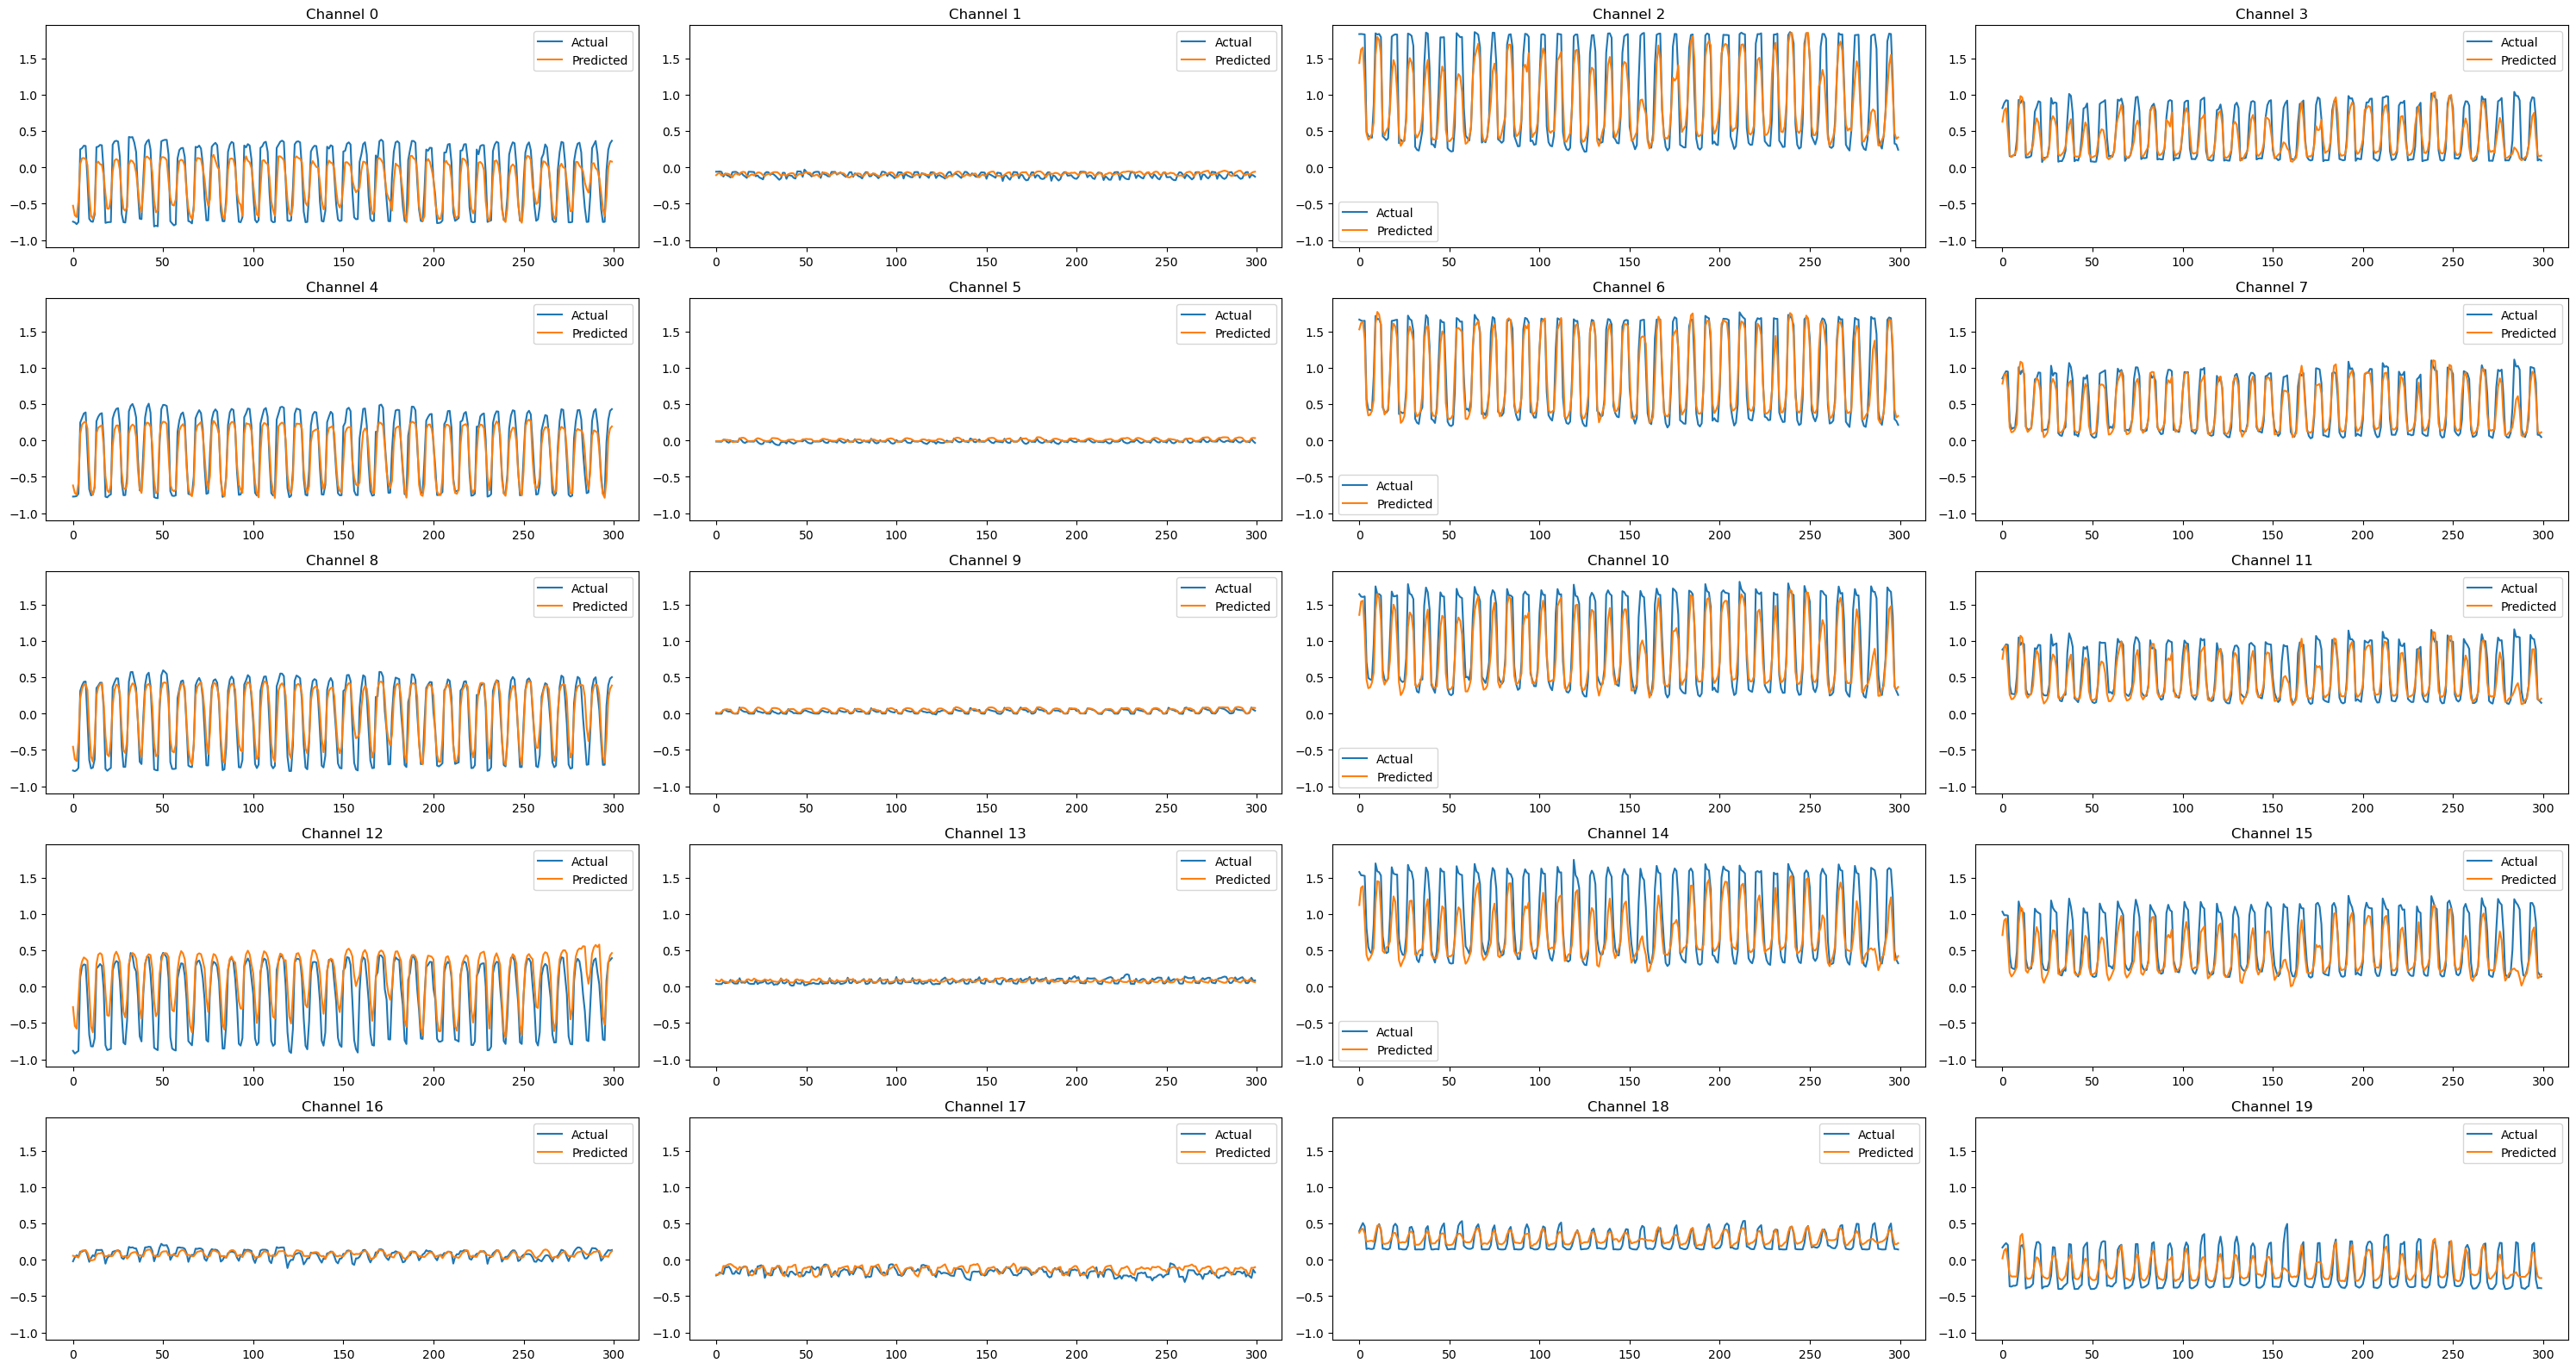

In [7]:
corrs = []
r2s = []
for chan in range(y_test.shape[1]):
    y_true_chan = y_test[:, chan]
    y_pred_chan = preds_batch[:, chan]

    # Pearson correlation
    c = corrcoef(y_pred_chan, y_true_chan)
    corrs.append(c)

    # R2 score
    # если все значения y_true одинаковы, r2_score вернёт ValueError,
    # можно в этом случае руками положить 0.0
    if np.allclose(y_true_chan, y_true_chan[0]):
        r2 = 0.0
    else:
        r2 = r2_score(y_true_chan, y_pred_chan)
    r2s.append(r2)

mean_corr = np.nanmean(corrs)
mean_r2 = np.nanmean(r2s)

# вывод результатов
results = {
    "all_correlations": corrs,
    "mean_correlation": np.nanmean(corrs),
    "std_correlation": np.nanstd(corrs),
    "all_r2": r2s,
    "mean_r2": np.nanmean(r2s),
    "std_r2": np.nanstd(r2s),
}

print(
    f'  Mean correlation: {results["mean_correlation"]:.3f} ± {results["std_correlation"]:.3f}'
)
print(
    f'  Individual correlations: {[f"{c:.3f}" for c in results["all_correlations"]]}\n'
)
print(f'  Mean R2: {results["mean_r2"]:.3f} ± {results["std_r2"]:.3f}')
print(f'  Individual R2: {[f"{r2:.3f}" for r2 in results["all_r2"]]}\n')

fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(30, 16))

# axs - это 4x5 массив осей
axs = axs.flatten()  # Преобразуем в 1D для удобства

for i in range(20):
    axs[i].plot(y_test[100:400, i])
    axs[i].plot(preds_batch[100:400, i])
    axs[i].set_title(f"Channel {i}")
    axs[i].legend(["Actual", "Predicted"])

ymin = min(y_test.min(), preds_batch.min())
ymax = max(y_test.max(), preds_batch.max())
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

#### Default Model

In [20]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


class TorchMLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_layer_sizes: list,
        output_dim: int,
        activation: str = "gelu",
        dropout_rate: float = 0.2,
        use_bn: bool = True,
        residual_connections: bool = False,
        init_method: str = "he",
    ):
        super(TorchMLP, self).__init__()
        self.residual_connections = residual_connections

        # Выбор активации
        activation_dict = {
            "relu": nn.ReLU,
            "gelu": nn.GELU,
            "selu": nn.SELU,
            "leaky_relu": nn.LeakyReLU,
            "swish": nn.SiLU,
        }
        act_layer = activation_dict.get(activation.lower(), nn.GELU)

        layers = []
        current_dim = input_dim

        # Построение скрытых слоев
        for i, h in enumerate(hidden_layer_sizes):
            # Линейный слой
            layers.append(nn.Linear(current_dim, h))

            # Инициализация весов
            if init_method == "he":
                nn.init.kaiming_normal_(layers[-1].weight, nonlinearity="relu")
            elif init_method == "xavier":
                nn.init.xavier_normal_(layers[-1].weight)

            # Batch Normalization
            if use_bn:
                layers.append(nn.BatchNorm1d(h))

            # Активация
            layers.append(act_layer())

            # Dropout
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))

            # Обновление размерности
            current_dim = h

        # Выходной слой
        self.output_layer = nn.Linear(current_dim, output_dim)

        # Инициализация выходного слоя
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.constant_(self.output_layer.bias, 0)

        self.layers = nn.ModuleList(layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        for layer in self.layers:
            if isinstance(layer, nn.Linear) and self.residual_connections:
                if x.shape[-1] == layer.out_features:
                    residual = x
                x = layer(x)
                if x.shape == residual.shape:
                    x += residual
                    residual = x
            else:
                x = layer(x)
        return self.output_layer(x)


class RiemannMLPRegressor(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        estimator="oas",
        metric="riemann",
        hidden_layer_sizes=(200,),
        activation="relu",
        solver="adam",
        alpha=1e-5,
        max_iter=200,
        random_state=None,
        device="cpu",
        batch_size=64,
        verbose=False,
    ):
        self.estimator = estimator
        self.metric = metric
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.solver = solver
        self.alpha = alpha
        self.max_iter = max_iter
        self.random_state = random_state
        self.device = device
        self.batch_size = batch_size
        self.verbose = verbose

        self.cov_ = None
        self.ts_ = None
        self.model_ = None

    # Изменённый метод fit принимает дополнительно X_val и y_val для вычисления тестового лосса и корреляции
    def fit(self, X, y, X_val=None, y_val=None):
        # Вычисление ковариаций и переход в тангенциальное пространство
        self.cov_ = Covariances(estimator=self.estimator)
        X_cov = self.cov_.fit_transform(X)
        self.ts_ = TangentSpace(metric=self.metric)
        X_ts = self.ts_.fit_transform(X_cov)

        print("X_cov.shape:", X_cov.shape)
        print("X_ts.shape:", X_ts.shape)

        X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).to(self.device)

        input_dim = X_ts.shape[1]
        output_dim = y_tensor.shape[1]

        self.model_ = TorchMLP(
            input_dim=input_dim,
            hidden_layer_sizes=self.hidden_layer_sizes,
            output_dim=output_dim,
            activation=self.activation,
            dropout_rate=0,
            use_bn=False,
            residual_connections=False,
            init_method="no",
        ).to(self.device)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            self.model_.parameters(), lr=0.001, weight_decay=self.alpha
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)

        dataset = torch.utils.data.TensorDataset(X_ts, y_tensor)
        loader = torch.utils.data.DataLoader(
            dataset, batch_size=self.batch_size, shuffle=True
        )

        # Если заданы данные для валидации, подготовим их
        if (X_val is not None) and (y_val is not None):
            X_cov_val = self.cov_.transform(X_val)
            X_ts_val = self.ts_.transform(X_cov_val)
            X_ts_val = torch.tensor(X_ts_val, dtype=torch.float32).to(self.device)
            y_tensor_val = torch.tensor(y_val, dtype=torch.float32).to(self.device)

        # Обучение модели
        for epoch in range(self.max_iter):
            self.model_.train()
            epoch_loss = 0
            for X_batch, y_batch in loader:
                optimizer.zero_grad()
                output = self.model_(X_batch)
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            scheduler.step()

            # Каждые 50 эпох (или можно менять условие) вычисляем и выводим метрики
            if self.verbose and ((epoch + 1) % 5 == 0):
                # Рассчёт метрик на тренировочных данных
                self.model_.eval()
                with torch.no_grad():
                    # Предсказания на тренинге
                    train_preds = self.model_(X_ts).cpu().numpy()
                    train_loss = criterion(self.model_(X_ts), y_tensor).item()

                    # Вычисление корреляции по каждому выходу
                    train_corrs = []
                    y_true_np = y_tensor.cpu().numpy()
                    for i in range(train_preds.shape[1]):
                        train_corrs.append(corrcoef(train_preds[:, i], y_true_np[:, i]))
                    train_mean_corr = np.nanmean(train_corrs)

                    metrics_str = f"Epoch {epoch+1}/{self.max_iter}: Train Loss: {train_loss:.4f}, Train Corr: {train_mean_corr:.3f}"

                    # Если есть валидация – аналогичные расчёты
                    if (X_val is not None) and (y_val is not None):
                        val_preds = self.model_(X_ts_val).cpu().numpy()
                        val_loss = criterion(self.model_(X_ts_val), y_tensor_val).item()
                        val_corrs = []
                        y_val_np = y_tensor_val.cpu().numpy()
                        for i in range(val_preds.shape[1]):
                            val_corrs.append(corrcoef(val_preds[:, i], y_val_np[:, i]))
                        val_mean_corr = np.nanmean(val_corrs)
                        metrics_str += (
                            f", Val Loss: {val_loss:.4f}, Val Corr: {val_mean_corr:.3f}"
                        )

                    print(metrics_str)

        return self

    def predict(self, X):
        X_cov = self.cov_.transform(X)
        X_ts = self.ts_.transform(X_cov)
        X_ts = torch.tensor(X_ts, dtype=torch.float32).to(self.device)
        self.model_.eval()
        with torch.no_grad():
            preds = self.model_(X_ts).cpu().numpy()
        return preds


model = RiemannMLPRegressor(
    estimator="oas",
    metric="riemann",
    hidden_layer_sizes=(256, 256),
    activation="gelu",
    max_iter=30,
    alpha=1e-5,
    random_state=42,
    device="cuda" if torch.cuda.is_available() else "cpu",
    verbose=True,
)

model.fit(X_train, y_train, X_test, y_test)
y_model_pred = model.predict(X_test)

results = {}
correlations = []
r2_list = []

for i in range(y_test.shape[1]):
    # corr
    try:
        corr = corrcoef(y_model_pred[:, i], y_test[:, i])
        correlations.append(corr)
    except:
        correlations.append(0.0)
    # r2
    try:
        r2 = r2_score(y_test[:, i], y_model_pred[:, i])
    except:
        r2 = np.nan
    r2_list.append(r2)

results["model"] = {
    "all_correlations": correlations,
    "mean_correlation": np.nanmean(correlations),
    "std_correlation": np.nanstd(correlations),
    "all_r2": r2_list,
    "mean_r2": np.nanmean(r2_list),
    "std_r2": np.nanstd(r2_list),
}

for name, metrics in results.items():
    print(f"{name}:")
    print(
        f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
    )
    print(
        f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
    )
    print(f'  Mean R2: {metrics["mean_r2"]:.3f} ± {metrics["std_r2"]:.3f}')
    print(f'  Individual R2: {[f"{r2:.3f}" for r2 in metrics["all_r2"]]}\n')

X_cov.shape: (7102, 6, 6)
X_ts.shape: (7102, 21)
Epoch 5/30: Train Loss: 0.0398, Train Corr: 0.819, Val Loss: 0.1739, Val Corr: 0.291
Epoch 10/30: Train Loss: 0.0332, Train Corr: 0.848, Val Loss: 0.1705, Val Corr: 0.250
Epoch 15/30: Train Loss: 0.0299, Train Corr: 0.864, Val Loss: 0.1778, Val Corr: 0.228
Epoch 20/30: Train Loss: 0.0282, Train Corr: 0.874, Val Loss: 0.1827, Val Corr: 0.226
Epoch 25/30: Train Loss: 0.0273, Train Corr: 0.878, Val Loss: 0.2016, Val Corr: 0.185
Epoch 30/30: Train Loss: 0.0245, Train Corr: 0.888, Val Loss: 0.1978, Val Corr: 0.193
model:
  Mean correlation: 0.193 ± 0.164
  Individual correlations: ['0.045', '0.277', '0.121', '0.001', '0.293', '0.293', '0.272', '0.151', '0.481', '0.286', '0.523', '0.372', '0.016', '0.225', '0.058', '-0.028', '0.047', '0.014', '0.376', '0.041']

  Mean R2: -0.385 ± 0.362
  Individual R2: ['-0.369', '-0.603', '-0.336', '-0.653', '-0.052', '-0.599', '-0.067', '-0.331', '0.213', '-0.617', '0.221', '-0.098', '-0.456', '-0.432', '-0

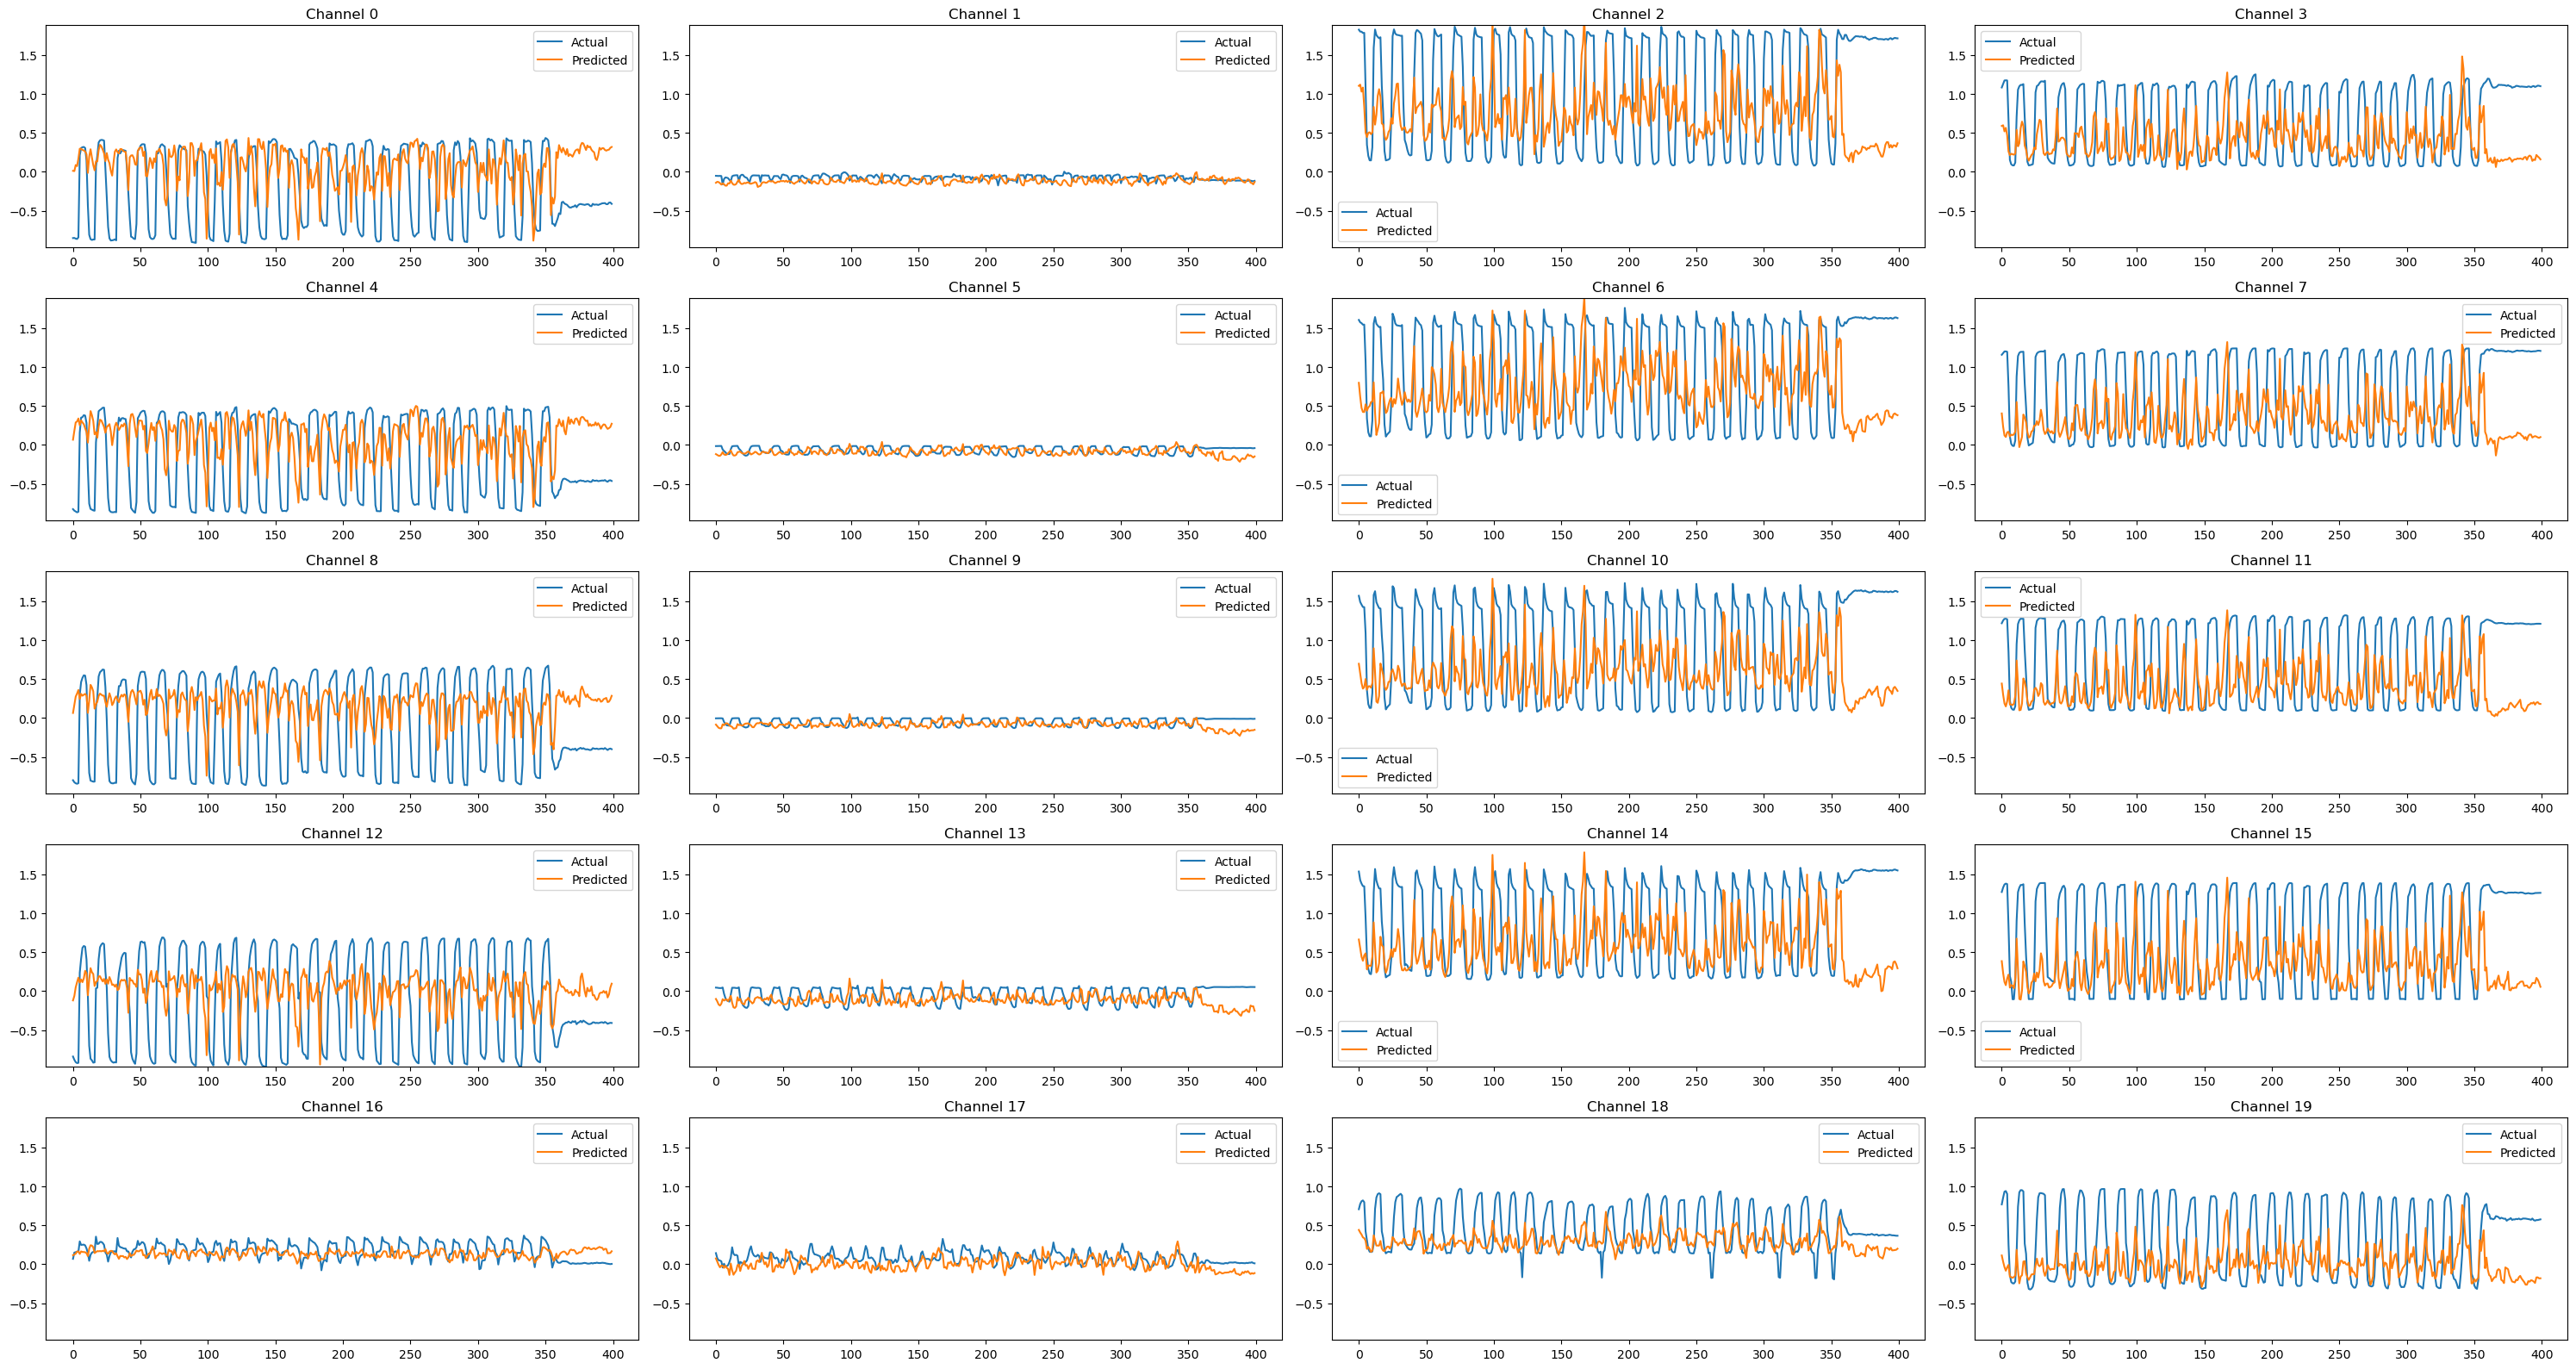

In [21]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(30, 16))

# axs - это 4x5 массив осей
axs = axs.flatten()  # Преобразуем в 1D для удобства

for i in range(20):
    axs[i].plot(y_test[0:400, i])
    axs[i].plot(y_model_pred[0:400, i])
    axs[i].set_title(f"Channel {i}")
    axs[i].legend(["Actual", "Predicted"])

ymin = min(y_test.min(), preds_batch.min())
ymax = max(y_test.max(), preds_batch.max())
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

#### Notes

Fedor
"Обучение на одном дне и предсказание на другом"

train_files_subnames = [
    "Simple2_1",
    "Simple2_2",
    "Simple2_3",
    "Simple2_4",
    "Simple2_5",
]
test_files_subnames = [
    "Simple1_1",
    "Simple1_2",
    "Simple1_3",
    "Simple1_4",
    "Simple1_5",
]

Epoch 0/50 | AvgBatchLoss: 0.3088 | Train MSE: 0.0195, Corr: 0.867, R2: 0.753 | Val MSE: 0.0510, Corr: 0.763, R2: 0.536
Epoch 5/50 | AvgBatchLoss: 0.0802 | Train MSE: 0.0097, Corr: 0.930, R2: 0.866 | Val MSE: 0.0445, Corr: 0.796, R2: 0.557
Epoch 10/50 | AvgBatchLoss: 0.0671 | Train MSE: 0.0080, Corr: 0.940, R2: 0.883 | Val MSE: 0.0396, Corr: 0.813, R2: 0.598
Epoch 15/50 | AvgBatchLoss: 0.0599 | Train MSE: 0.0067, Corr: 0.948, R2: 0.895 | Val MSE: 0.0314, Corr: 0.838, R2: 0.655
Epoch 20/50 | AvgBatchLoss: 0.0556 | Train MSE: 0.0062, Corr: 0.951, R2: 0.904 | Val MSE: 0.0300, Corr: 0.833, R2: 0.640
Epoch 25/50 | AvgBatchLoss: 0.0525 | Train MSE: 0.0051, Corr: 0.957, R2: 0.915 | Val MSE: 0.0319, Corr: 0.835, R2: 0.652
Epoch 30/50 | AvgBatchLoss: 0.0509 | Train MSE: 0.0058, Corr: 0.954, R2: 0.909 | Val MSE: 0.0315, Corr: 0.834, R2: 0.649
Epoch 35/50 | AvgBatchLoss: 0.0502 | Train MSE: 0.0052, Corr: 0.958, R2: 0.917 | Val MSE: 0.0301, Corr: 0.842, R2: 0.663 !!!!!
Epoch 40/50 | AvgBatchLoss: 0.0494 | Train MSE: 0.0049, Corr: 0.958, R2: 0.918 | Val MSE: 0.0335, Corr: 0.834, R2: 0.648
Epoch 45/50 | AvgBatchLoss: 0.0486 | Train MSE: 0.0047, Corr: 0.959, R2: 0.919 | Val MSE: 0.0318, Corr: 0.840, R2: 0.650
Batch MSE: 0.02995285743323588
---------------
0.842, 0.663 (не забыть сказать что было всего два дня записи один из которых первый и участник мог не сразу понять как правильно делать + большой перерыв между двумя днями)

Fedor
"Кросс валидация по тренировочным циклам"

train_files_subnames = [
    "Simple2_1",
    "Simple2_2",
    "Simple2_3",
    "Simple2_4",
    "Simple2_5",
    "Simple1_1",
    "Simple1_2",
    "Simple1_3",
]
test_files_subnames = [
    "Simple1_4",
    "Simple1_5",
]

Mean correlation: 0.915 ± 0.093
  Individual correlations: ['0.951', '0.694', '0.977', '0.985', '0.943', '0.772', '0.973', '0.976', '0.965', '0.816', '0.965', '0.966', '0.973', '0.676', '0.962', '0.963', '0.940', '0.939', '0.914', '0.949']

  Mean R2: 0.827 ± 0.177
  Individual R2: ['0.897', '0.425', '0.950', '0.968', '0.862', '0.575', '0.944', '0.949', '0.923', '0.653', '0.925', '0.926', '0.946', '0.336', '0.918', '0.919', '0.849', '0.857', '0.826', '0.885']

0.915, 0.827
0.895, 0.794
0.894, 0.780
------------
0.901, 0.803

0.8982 ± 0.0125
0.8028 ± 0.0176

Oleg
"Cross-validation"

Test: Simple5, Simple4,  Simple3, Simple2, Simple1
0.869, 0.743
0.817, 0.654
0.894, 0.784
0.833, 0.659


In [ ]:
print(
    np.array([[0.869, 0.817, 0.894, 0.833], [0.743, 0.654, 0.784, 0.659]]).mean(axis=1)
)
print(
    np.array([[0.869, 0.817, 0.894, 0.833], [0.743, 0.654, 0.784, 0.659]]).std(axis=1)
)

[0.85325 0.71   ]
[0.03013615 0.05545719]


Alexander Chevcov
"Validation V2"

0.848, 0.697
0.728, 0.446
0.782, 0.584

In [37]:
arr = np.array([[0.848, 0.782], [0.697, 0.584]])
print(arr.mean(axis=1))
print(arr.std(axis=1))

[0.815  0.6405]
[0.033  0.0565]


Peter
"Validation V2"

0.857 ± 0.03
0.727 ± 0.06

Alexander K
"Validation V2"

Mean correlation: 0.872 ± 0.036
Individual correlations: ['0.887', '0.847', '0.868', '0.850', '0.854', '0.895', '0.907', '0.899', '0.850', '0.824', '0.914', '0.903', '0.887', '0.871', '0.923', '0.892', '0.818', '0.773', '0.894', '0.888']

Mean R2: 0.749 ± 0.065
Individual R2: ['0.774', '0.716', '0.748', '0.717', '0.706', '0.798', '0.816', '0.804', '0.688', '0.674', '0.829', '0.809', '0.772', '0.755', '0.850', '0.793', '0.663', '0.578', '0.748', '0.736']